# Example for option price models

In [1]:
%load_ext autoreload
%autoreload 2

import price_models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

### We define both a call and a put option according to the Black-Scholes model

In [2]:
strike = 105
bsm_call = price_models.BlackScholesModel(strike, "C") # Call option
bsm_put  = price_models.BlackScholesModel(strike, "P") # Put option

### Furthermore, we can compute its value according to the option pricing model

In [3]:
S0 = 100
T = 1/12 # 1 month out
vol = 0.14
r = 0.05

bsm_call.value(S0, T, vol=vol, r=r), bsm_put.value(S0, T, vol=vol, r=r)

(28.122556195157422, 484.4635755688117)

### We plot a series of spot prices `S0` for different expiration times `T`

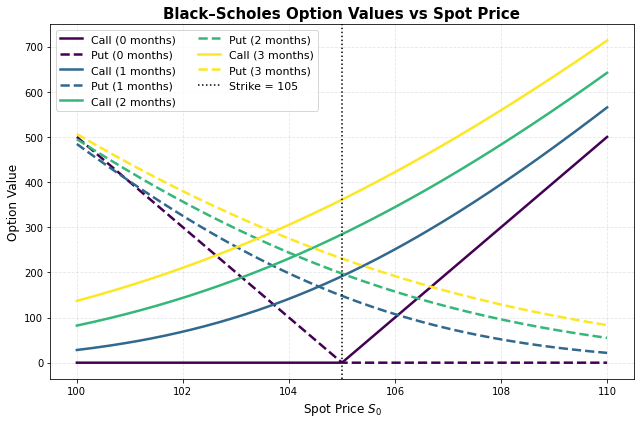

In [4]:
# Parameters
S0_arr = np.linspace(100, 110, 200)  # spot prices
vol = 0.14
r = 0.05
T_arr = np.array([0, 1, 2, 3]) / 12   # 1, 2, 3 months in years
strike = 105  # strike

# Colormap for different maturities
colors = cm.viridis(np.linspace(0, 1, len(T_arr)))

plt.figure(figsize=(9, 6))

for i, T in enumerate(T_arr):
    call_vals = bsm_call.value(S0_arr, T, vol=vol, r=r)
    put_vals = bsm_put.value(S0_arr, T, vol=vol, r=r)

    # same color, solid = call, dashed = put
    plt.plot(S0_arr, call_vals, color=colors[i], linestyle="-", linewidth=2.5, label=f"Call ({i} months)")
    plt.plot(S0_arr, put_vals, color=colors[i], linestyle="--", linewidth=2.5, label=f"Put ({i} months)")
 
# Strike reference line
plt.axvline(strike, color="black", linestyle=":", linewidth=1.5, label=f"Strike = {strike}")

# Formatting
plt.title("Black–Scholes Option Values vs Spot Price", fontsize=15, weight="bold")
plt.xlabel("Spot Price $S_0$", fontsize=12)
plt.ylabel("Option Value", fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
plt.show()

### Now we define a call and a put option according to class `NoArbitrageModel`, which, given any `stock_price_model`, computes option prices in an arbitrage-free way

### We first use the geometric Brownian motion as `stock_price_model`. This should be equivalent as the Black-Scholes model, since no arbitrage is embedded in its construction

### Define the objects

In [5]:
gbm = price_models.GBMModel() # Geometric Brownian motion model
nam_gbm_call = price_models.NoArbitrageModel(strike, "C", gbm) # Call option
nam_gbm_put  = price_models.NoArbitrageModel(strike, "P", gbm) # Put option

### Compute the value of the options according to our model and compare it to the Black-Scholes model. They should be equivalent up to fluctuations 

In [6]:
S0 = 105
T = 1/12 # 1 month out
r = 0.05
vol = 0.2
N_paths = 100_000
print("According to No-Arbitrage model:")
print(f"Call's value: {nam_gbm_call.value(S0, T, vol=vol, r=r, N_paths=N_paths):.2f}. Put's value: {nam_gbm_put.value(S0, T, vol=vol, r=r, N_paths=N_paths):.2f}")
print("For comparison, we display the 'fair price' according to Black-Scholes:")
print(f"Call's value: {bsm_call.value(S0, T, vol=vol, r=r):.2f}. Put's value: {bsm_put.value(S0, T, vol=vol, r=r):.2f}")

According to No-Arbitrage model:
Call's value: 265.04. Put's value: 220.89
For comparison, we display the 'fair price' according to Black-Scholes:
Call's value: 263.77. Put's value: 220.11


### Now we use the class `EmpiricalReturnModel` as our `stock_price_model`

In [7]:
data = pd.read_csv("SPY_close_price.csv") # Upload data
data = data["Close"]
emp = price_models.EmpiricalReturnModel(data, period="day") # Define model based on historical data

nam_emp_call = price_models.NoArbitrageModel(strike, "C", emp) # Call option
nam_emp_put = price_models.NoArbitrageModel(strike, "P", emp) # Put option

Interpolating probability distribution function...
Interpolation finished.


### We compute the values of the options according to this model

In [8]:
print(f"Call's value: {nam_emp_call.value(S0, T, r=r, N_paths=N_paths, method='kde'):.2f}. Put's value: {nam_emp_put.value(S0, T, r=r, N_paths=N_paths, method='kde'):.2f}")

Call's value: 279.09. Put's value: 177.58


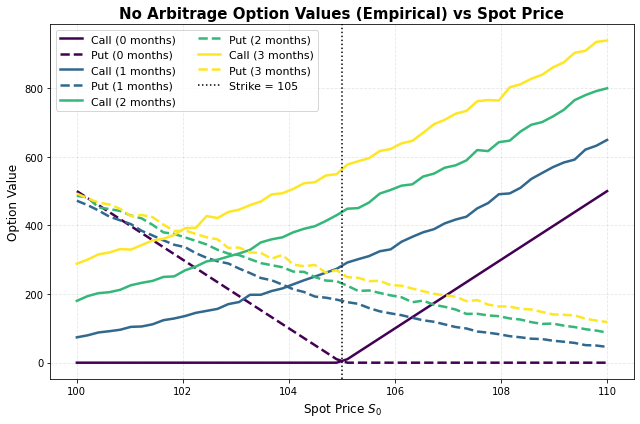

In [9]:
# Parameters
S0_arr = np.linspace(100, 110, 50)  # spot prices
r = 0.05
T_arr = np.array([0, 1, 2, 3]) / 12   # 1, 2, 3 months in years
strike = 105  # strike
N_paths=10_000

# Colormap for different maturities
colors = cm.viridis(np.linspace(0, 1, len(T_arr)))

plt.figure(figsize=(9, 6))

for i, T in enumerate(T_arr):
    for S0 in S0_arr:
        call_vals = [nam_emp_call.value(S0, T, r=r, N_paths=N_paths, method="kde") for S0 in S0_arr]
        put_vals = [nam_emp_put.value(S0, T, r=r, N_paths=N_paths, method="kde") for S0 in S0_arr]

    # same color, solid = call, dashed = put
    plt.plot(S0_arr, call_vals, color=colors[i], linestyle="-", linewidth=2.5, label=f"Call ({i} months)")
    plt.plot(S0_arr, put_vals, color=colors[i], linestyle="--", linewidth=2.5, label=f"Put ({i} months)")
 
# Strike reference line
plt.axvline(strike, color="black", linestyle=":", linewidth=1.5, label=f"Strike = {strike}")

# Formatting
plt.title("No Arbitrage Option Values (Empirical) vs Spot Price", fontsize=15, weight="bold")
plt.xlabel("Spot Price $S_0$", fontsize=12)
plt.ylabel("Option Value", fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
plt.savefig("no_arbitrage_options.png", dpi=300)
plt.show()